# Introduction
### A few words

Submitted versions are versions 4 and 5 that score **30.7 and 30.3 on public**. The only difference is that I used different class sampling probabilities for generating images. The solution proposed here is legit, no memorization of any kind is made.

If you wish to evaluate the results locally, make sure to add the metric dataset, change the PATH varaibles and uncomment the scoring lines.

### References

- NVIDIA's Progressive Growing of GANs paper : https://research.nvidia.com/publication/2017-10_Progressive-Growing-of
- CGANs with Projection Discriminator : https://arxiv.org/pdf/1802.05637.pdf
- The modeling part of the kernel is taken from : https://github.com/akanimax/pro_gan_pytorch

# Imports

In [1]:
import re
import gc
import os
import cv2
import copy
import time
import pickle
import random
import shutil
import urllib
import pathlib
import datetime
import operator
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from PIL import Image
from scipy import linalg
from sklearn.metrics import *
from collections import Counter
from scipy.stats import truncnorm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool, cpu_count
from sklearn.preprocessing import LabelEncoder

import torch
import torch as th
import torch.nn as nn
import torch.utils.data
import torchvision as tv
import torch.nn.functional as F
import torchvision.models as models

from torch.optim import Adam
from torch.nn import Parameter

from torchvision.datasets import *
from torch.autograd import Variable
from torch.optim.lr_scheduler import *
from torchvision.utils import save_image
from torchvision.datasets.folder import *
from torch.nn.functional import interpolate
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import Conv2d, BCEWithLogitsLoss, DataParallel, AvgPool2d, ModuleList, LeakyReLU, ConvTranspose2d, Embedding

begin = time.time()
sns.set_style('white')
warnings.simplefilter(action='ignore', category=FutureWarning) 
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Initialization

## Load Data

In [2]:
KERNEL_START_TIME = time.time()

In [3]:
DATA_PATH = '../input/all-dogs/all-dogs/'
IMAGE_FOLDER = '../input/all-dogs'
IMAGES = [DATA_PATH + p for p in os.listdir(DATA_PATH)]
ANNOTATION_PATH = '../input/annotation/Annotation'

print('Number of doge images :', len(IMAGES))

Number of doge images : 20579


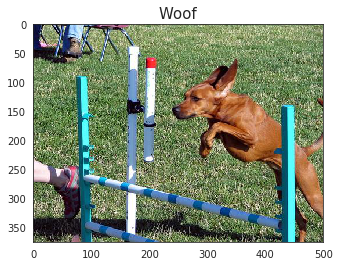

In [4]:
img = Image.open(IMAGES[0])
plt.imshow(img)
plt.title('Woof', size=15)
plt.show()

## Seeding

Although I used the usual seeding rooting, that is supposed to ensure reproductible results, there is still some randomness in this kernel. Not sure why.

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

In [6]:
seed = 2019
seed_everything(seed)

# Datasets

## Transforms
- RandomHorizontalFlip, p=0.5
- CenterCrop or RandomCrop
- A bit of ColorJitter
- Rescale between [-1, 1]

Rotating is not used, and I also tried other normalization methods.

In [7]:
class Rescale():
    def __init__(self):
        self.a = 2
        self.b = -1
        
    def __call__(self, tensor):
        return tensor.mul(self.a).add(self.b)

    def __repr__(self):
        return self.__class__.__name__ + '(x{}, +{})'.format(self.a, self.b)

In [8]:
def get_transforms(size):
    base_transforms = transforms.Compose([transforms.Resize(size)])
    additional_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
#         transforms.RandomApply([transforms.RandomRotation(degrees=5)], p=0.5),
        transforms.RandomChoice([transforms.CenterCrop(size), transforms.RandomCrop(size)]),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=(0.9, 1.2), saturation=0.3, hue=0.01)], p=0.5),
        transforms.ToTensor(),
#         transforms.Normalize(means, stds),
        Rescale(),
    ])
    return base_transforms, additional_transforms

## Annotations Dataset
> Thanks to Guillaume Desforges

- I used dog boxes, but enlarge them by 10px on each side
- Dog races are also used

In [9]:
class DogeDataset(Dataset):
    def __init__(self, folder, base_transforms, additional_transforms):
        self.folder = folder
        self.classes = [dirname[10:] for dirname in os.listdir(ANNOTATION_PATH)]
        
        self.base_transforms = base_transforms
        self.additional_transforms = additional_transforms
        self.imgs, self.labels = self.load_subfolders_images(folder)
        
        le = LabelEncoder().fit(self.classes)
        self.y = torch.from_numpy(le.transform(self.labels)).long()
        self.classes = le.inverse_transform(range(len(self.classes)))
        
    def __getitem__(self, index):
        return self.additional_transforms(self.imgs[index]), self.y[index]

    def __len__(self):
        return len(self.imgs)
    
    @staticmethod
    def is_valid_file(x):
        img_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
        return has_file_allowed_extension(x, img_extensions)
    
    @staticmethod
    def get_bbox(o):
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        return xmin, ymin, xmax, ymax
    
    @staticmethod
    def larger_bbox(bbox, ximg, yimg, a=10):
        xmin, ymin, xmax, ymax = bbox
        xmin = max(xmin - a, 0)
        ymin = max(ymin - a, 0)
        xmax = min(xmax + a, ximg)
        ymax = min(ymax + a, yimg)
        return (xmin, ymin, xmax, ymax)
    
    def load_subfolders_images(self, root):
        imgs = []
        paths = []
        labels = []
        
        for root, _, fnames in sorted(os.walk(root)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if self.is_valid_file(path):
                    paths.append(path)

        for path in paths:
            img = default_loader(path)

            annotation_basename = os.path.splitext(os.path.basename(path))[0]
            annotation_dirname = next(dirname for dirname in os.listdir(ANNOTATION_PATH) if dirname.startswith(annotation_basename.split('_')[0]))
            annotation_filename = os.path.join(ANNOTATION_PATH, annotation_dirname, annotation_basename)
            label = annotation_dirname[10:]
            tree = ET.parse(annotation_filename)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bbox = self.get_bbox(o)
                bbox = self.larger_bbox(bbox, img.size[0], img.size[1])
                object_img = self.base_transforms(img.crop(bbox))
                imgs.append(object_img)
                labels.append(label)
        return imgs, labels

In [10]:
%%time
base_transforms, additional_transforms = get_transforms(64)
dataset = DogeDataset(DATA_PATH, base_transforms, additional_transforms)

CPU times: user 1min 18s, sys: 5.17 s, total: 1min 23s
Wall time: 1min 59s


In [11]:
nb_classes = len(dataset.classes)
print(f'Number of classes : {nb_classes}')

Number of classes : 120


In [12]:
nb_dogs = len(dataset)
print(f'Number of dogs : {nb_dogs}')

Number of dogs : 22125


# Metric
Not used for submission

In [13]:
WEIGHTS_PATH = '../input/dog-face-generation-competition-kid-metric-input/classify_image_graph_def.pb'

In [14]:
model_params = {
    'Inception': {
        'name': 'Inception', 
        'imsize': 64,
        'output_layer': 'Pretrained_Net/pool_3:0', 
        'input_layer': 'Pretrained_Net/ExpandDims:0',
        'output_shape': 2048,
        'cosine_distance_eps': 0.1
        }
}

In [15]:
class KernelEvalException(Exception):
    pass

In [16]:
def create_model_graph(pth):
    with tf.gfile.FastGFile( pth, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString( f.read())
        _ = tf.import_graph_def( graph_def, name='Pretrained_Net')

        
def _get_model_layer(sess, model_name):
    layername = model_params[model_name]['output_layer']
    layer = sess.graph.get_tensor_by_name(layername)
    ops = layer.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            if shape._dims != []:
                shape = [s.value for s in shape]
                new_shape = []
                for j, s in enumerate(shape):
                    if s == 1 and j == 0:
                        new_shape.append(None)
                    else:
                        new_shape.append(s)
                o.__dict__['_shape_val'] = tf.TensorShape(new_shape)
    return layer


def get_activations(images, sess, model_name, batch_size=50, verbose=False):
    inception_layer = _get_model_layer(sess, model_name)
    n_images = images.shape[0]
    if batch_size > n_images:
        print("warning: batch size is bigger than the data size. setting batch size to data size")
        batch_size = n_images
    n_batches = n_images//batch_size + 1
    pred_arr = np.empty((n_images,model_params[model_name]['output_shape']))
    for i in range(n_batches):
        if verbose:
            print("\rPropagating batch %d/%d" % (i+1, n_batches), end="", flush=True)
        start = i*batch_size
        if start+batch_size < n_images:
            end = start+batch_size
        else:
            end = n_images
                    
        batch = images[start:end]
        pred = sess.run(inception_layer, {model_params[model_name]['input_layer']: batch})
        pred_arr[start:end] = pred.reshape(-1,model_params[model_name]['output_shape'])
    if verbose:
        print(" done")
    return pred_arr

In [17]:
def normalize_rows(x: np.ndarray):
    return np.nan_to_num(x/np.linalg.norm(x, ord=2, axis=1, keepdims=True))


def cosine_distance(features1, features2):
    features1_nozero = features1[np.sum(features1, axis=1) != 0]
    features2_nozero = features2[np.sum(features2, axis=1) != 0]
    norm_f1 = normalize_rows(features1_nozero)
    norm_f2 = normalize_rows(features2_nozero)

    d = 1.0 - np.abs(np.matmul(norm_f1, norm_f2.T))
    mean_min_d = np.mean(np.min(d, axis=1))
    return mean_min_d


def distance_thresholding(d, eps):
    if d < eps:
        return d
    else:
        return 1

    
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        # covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean


def calculate_activation_statistics(images, sess, model_name, batch_size=50, verbose=False):
    act = get_activations(images, sess, model_name, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma, act


def _handle_path_memorization(path, sess, model_name, is_checksize, is_check_png):
    path = pathlib.Path(path)
    files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
    imsize = model_params[model_name]['imsize']

    # In production we don't resize input images. This is just for demo purpose. 
    x = np.array([np.array(img_read_checks(fn, imsize, is_checksize, imsize, is_check_png)) for fn in files])
    m, s, features = calculate_activation_statistics(x, sess, model_name)
    del x #clean up memory
    return m, s, features


def img_read_checks(filename, resize_to, is_checksize=False, check_imsize = 64, is_check_png = False):
    im = Image.open(str(filename))
    if is_checksize and im.size != (check_imsize,check_imsize):
        raise KernelEvalException('The images are not of size '+str(check_imsize))
    
    if is_check_png and im.format != 'PNG':
        raise KernelEvalException('Only PNG images should be submitted.')

    if resize_to is None:
        return im
    else:
        return im.resize((resize_to,resize_to),Image.ANTIALIAS)

    
def calculate_kid_given_paths(paths, model_name, model_path, feature_path=None):
    ''' Calculates the KID of two paths. '''
    tf.reset_default_graph()
    create_model_graph(str(model_path))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        m1, s1, features1 = _handle_path_memorization(paths[0], sess, model_name, is_checksize = True, is_check_png = True)
        if feature_path is None:
            m2, s2, features2 = _handle_path_memorization(paths[1], sess, model_name, is_checksize = False, is_check_png = False)
        else:
            with np.load(feature_path) as f:
                m2, s2, features2 = f['m'], f['s'], f['features']

#         print('m1,m2 shape=',(m1.shape,m2.shape),'s1,s2=',(s1.shape,s2.shape))
#         print('starting calculating FID')
        fid_value = calculate_frechet_distance(m1, s1, m2, s2)
#         print('done with FID, starting distance calculation')
        distance = cosine_distance(features1, features2)        
        return fid_value, distance

In [18]:
def compute_mifid(generated_path, real_path, graph_path, model_params, eps=10e-15):
    fid_value, distance = calculate_kid_given_paths([generated_path, real_path], 
                                                                  'Inception', graph_path)
    distance = distance_thresholding(distance, model_params['Inception']['cosine_distance_eps'])
    return fid_value / (distance + eps)

# Models

## Tools

### Spectral Normalization
> Taken from https://github.com/isr-wang/SNGAN

I played a bit with it, without success.

In [19]:
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

### Equalized Layers

In [20]:
# extending Conv2D and Deconv2D layers for equalized learning rate logic
class _equalized_conv2d(th.nn.Module):
    """ conv2d with the concept of equalized learning rate
        Args:
            :param c_in: input channels
            :param c_out:  output channels
            :param k_size: kernel size (h, w) should be a tuple or a single integer
            :param stride: stride for conv
            :param pad: padding
            :param bias: whether to use bias or not
    """

    def __init__(self, c_in, c_out, k_size, stride=1, pad=0, bias=True):
        """ constructor for the class """
        from torch.nn.modules.utils import _pair
        from numpy import sqrt, prod

        super(_equalized_conv2d, self).__init__()

        # define the weight and bias if to be used
        self.weight = th.nn.Parameter(th.nn.init.normal_(
            th.empty(c_out, c_in, *_pair(k_size))
        ))

        self.use_bias = bias
        self.stride = stride
        self.pad = pad

        if self.use_bias:
            self.bias = th.nn.Parameter(th.FloatTensor(c_out).fill_(0))

        fan_in = prod(_pair(k_size)) * c_in  # value of fan_in
        self.scale = sqrt(2) / sqrt(fan_in)

    def forward(self, x):
        """
        forward pass of the network
        :param x: input
        :return: y => output
        """
        from torch.nn.functional import conv2d

        return conv2d(input=x,
                      weight=self.weight * self.scale,  # scale the weight on runtime
                      bias=self.bias if self.use_bias else None,
                      stride=self.stride,
                      padding=self.pad)

    def extra_repr(self):
        return ", ".join(map(str, self.weight.shape))


class _equalized_deconv2d(th.nn.Module):
    """ Transpose convolution using the equalized learning rate
        Args:
            :param c_in: input channels
            :param c_out: output channels
            :param k_size: kernel size
            :param stride: stride for convolution transpose
            :param pad: padding
            :param bias: whether to use bias or not
    """

    def __init__(self, c_in, c_out, k_size, stride=1, pad=0, bias=True):
        """ constructor for the class """
        from torch.nn.modules.utils import _pair
        from numpy import sqrt

        super(_equalized_deconv2d, self).__init__()

        # define the weight and bias if to be used
        self.weight = th.nn.Parameter(th.nn.init.normal_(
            th.empty(c_in, c_out, *_pair(k_size))
        ))

        self.use_bias = bias
        self.stride = stride
        self.pad = pad

        if self.use_bias:
            self.bias = th.nn.Parameter(th.FloatTensor(c_out).fill_(0))

        fan_in = c_in  # value of fan_in for deconv
        self.scale = sqrt(2) / sqrt(fan_in)

    def forward(self, x):
        """
        forward pass of the layer
        :param x: input
        :return: y => output
        """
        from torch.nn.functional import conv_transpose2d

        return conv_transpose2d(input=x,
                                weight=self.weight * self.scale,  # scale the weight on runtime
                                bias=self.bias if self.use_bias else None,
                                stride=self.stride,
                                padding=self.pad)

    def extra_repr(self):
        return ", ".join(map(str, self.weight.shape))


class _equalized_linear(th.nn.Module):
    """ Linear layer using equalized learning rate
        Args:
            :param c_in: number of input channels
            :param c_out: number of output channels
            :param bias: whether to use bias with the linear layer
    """

    def __init__(self, c_in, c_out, bias=True):
        """
        Linear layer modified for equalized learning rate
        """
        from numpy import sqrt

        super(_equalized_linear, self).__init__()

        self.weight = th.nn.Parameter(th.nn.init.normal_(
            th.empty(c_out, c_in)
        ))

        self.use_bias = bias

        if self.use_bias:
            self.bias = th.nn.Parameter(th.FloatTensor(c_out).fill_(0))

        fan_in = c_in
        self.scale = sqrt(2) / sqrt(fan_in)

    def forward(self, x):
        """
        forward pass of the layer
        :param x: input
        :return: y => output
        """
        from torch.nn.functional import linear
        return linear(x, self.weight * self.scale,
                      self.bias if self.use_bias else None)

### Pixelwise Normalization

In [21]:
class PixelwiseNorm(th.nn.Module):
    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the module
        :param x: input activations volume
        :param alpha: small number for numerical stability
        :return: y => pixel normalized activations
        """
        y = x.pow(2.).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y  # normalize the input x volume
        return y

### Minibatch Standard Deviation

In [22]:
class MinibatchStdDev(th.nn.Module):
    """
    Minibatch standard deviation layer for the discriminator
    """
    def __init__(self):
        """
        derived class constructor
        """
        super(MinibatchStdDev, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the layer
        :param x: input activation volume
        :param alpha: small number for numerical stability
        :return: y => x appended with standard deviation constant map
        """
        batch_size, _, height, width = x.shape

        # [B x C x H x W] Subtract mean over batch.
        y = x - x.mean(dim=0, keepdim=True)

        # [1 x C x H x W]  Calc standard deviation over batch
        y = th.sqrt(y.pow(2.).mean(dim=0, keepdim=False) + alpha)

        # [1]  Take average over feature_maps and pixels.
        y = y.mean().view(1, 1, 1, 1)

        # [B x 1 x H x W]  Replicate over group and pixels.
        y = y.repeat(batch_size, 1, height, width)

        # [B x C x H x W]  Append as new feature_map.
        y = th.cat([x, y], 1)

        # return the computed values:
        return y

### Generator Blocks

In [23]:
class GenInitialBlock(th.nn.Module):
    def __init__(self, in_channels, use_eql, use_spec_norm=False):
        super(GenInitialBlock, self).__init__()

        if use_eql:
            self.conv_1 = _equalized_deconv2d(in_channels, in_channels, (4, 4), bias=True)
            self.conv_2 = _equalized_conv2d(in_channels, in_channels, (3, 3), pad=1, bias=True)

        else:
            self.conv_1 = ConvTranspose2d(in_channels, in_channels, (4, 4), bias=True)
            self.conv_2 = Conv2d(in_channels, in_channels, (3, 3), padding=1, bias=True)

        if use_spec_norm:
            self.conv_1 = SpectralNorm(self.conv_1)
            self.conv_2 = SpectralNorm(self.conv_2)
            
        self.pixNorm = PixelwiseNorm()
        self.lrelu = LeakyReLU(0.2)
        
    def forward(self, x):
        # convert the tensor shape:
        y = th.unsqueeze(th.unsqueeze(x, -1), -1)

        # perform the forward computations:
        y = self.lrelu(self.conv_1(y))
        y = self.lrelu(self.conv_2(y))
        y = self.pixNorm(y)
        
        return y

In [24]:
class GenGeneralConvBlock(th.nn.Module):
    def __init__(self, in_channels, out_channels, use_eql, use_spec_norm=False):
        super(GenGeneralConvBlock, self).__init__()

        self.upsample = lambda x: interpolate(x, scale_factor=2)

        if use_eql:
            self.conv_1 = _equalized_conv2d(in_channels, out_channels, (3, 3),
                                            pad=1, bias=True)
            self.conv_2 = _equalized_conv2d(out_channels, out_channels, (3, 3),
                                            pad=1, bias=True)
        else:
            self.conv_1 = Conv2d(in_channels, out_channels, (3, 3),
                                 padding=1, bias=True)
            self.conv_2 = Conv2d(out_channels, out_channels, (3, 3),
                                 padding=1, bias=True)
        
        if use_spec_norm:
            self.conv_1 = SpectralNorm(self.conv_1)
            self.conv_2 = SpectralNorm(self.conv_2)
            
        self.pixNorm = PixelwiseNorm()
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x):
        """
        forward pass of the block
        :param x: input
        :return: y => output
        """
        y = self.upsample(x)
        y = self.pixNorm(self.lrelu(self.conv_1(y)))
        y = self.pixNorm(self.lrelu(self.conv_2(y)))
        
        return y

### Discriminator Blocks

In [25]:
class DisGeneralConvBlock(th.nn.Module):
    """ General block in the discriminator  """

    def __init__(self, in_channels, out_channels, use_eql, use_spec_norm=False):
        """
        constructor of the class
        :param in_channels: number of input channels
        :param out_channels: number of output channels
        :param use_eql: whether to use equalized learning rate
        """
        super(DisGeneralConvBlock, self).__init__()
        
        if use_eql:
            self.conv_1 = _equalized_conv2d(in_channels, in_channels, (3, 3), pad=1, bias=True)
            self.conv_2 = _equalized_conv2d(in_channels, out_channels, (3, 3), pad=1, bias=True)
        else:
            self.conv_1 = Conv2d(in_channels, in_channels, (3, 3), padding=1, bias=True)
            self.conv_2 = Conv2d(in_channels, out_channels, (3, 3), padding=1, bias=True)
            
        if use_spec_norm:
            self.conv_1 = SpectralNorm(self.conv_1)
            self.conv_2 = SpectralNorm(self.conv_2)

        self.downSampler = AvgPool2d(2)
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x):
        y = self.lrelu(self.conv_1(x))
        y = self.lrelu(self.conv_2(y))
        y = self.downSampler(y)
        return y

In [26]:
class ConDisFinalBlock(th.nn.Module):
    def __init__(self, in_channels, num_classes, use_eql):
        super(ConDisFinalBlock, self).__init__()

        # declare the required modules for forward pass
        self.batch_discriminator = MinibatchStdDev()
        if use_eql:
            self.conv_1 = _equalized_conv2d(in_channels + 1, in_channels, (3, 3), pad=1, bias=True)
            self.conv_2 = _equalized_conv2d(in_channels, in_channels, (4, 4), bias=True)

            # final conv layer emulates a fully connected layer
            self.conv_3 = _equalized_conv2d(in_channels, 1, (1, 1), bias=True)
        else:
            self.conv_1 = Conv2d(in_channels + 1, in_channels, (3, 3), padding=1, bias=True)
            self.conv_2 = Conv2d(in_channels, in_channels, (4, 4), bias=True)

            # final conv layer emulates a fully connected layer
            self.conv_3 = Conv2d(in_channels, 1, (1, 1), bias=True)

        # we also need an embedding matrix for the label vectors
        self.label_embedder = Embedding(num_classes, in_channels, max_norm=1)

        # leaky_relu:
        self.lrelu = LeakyReLU(0.2)
        
        # for ft matching
        nb_ft = 128
        self.ft_matching_dense = nn.Linear(2 * in_channels, nb_ft)

    def forward(self, x, labels, return_ft=False):
        """
        forward pass of the FinalBlock
        :param x: input
        :param labels: samples' labels for conditional discrimination
                       Note that these are pure integer labels [Batch_size x 1]
        :return: y => output
        """
        batch_size = x.size()[0]
        # minibatch_std_dev layer
        y = self.batch_discriminator(x)  # [B x C x 4 x 4]

        # perform the forward pass
        y = self.lrelu(self.conv_1(y))  # [B x C x 4 x 4]

        # obtain the computed features
        y = self.lrelu(self.conv_2(y))  # [B x C x 1 x 1]
        y_ = y.view((batch_size, -1))  # [B x C]
        
        # embed the labels
        labels = self.label_embedder(labels.cuda()).view((batch_size, -1))  # [B x C]

        # compute the inner product with the label embeddings
        
        if return_ft:
            self.ft_matching_dense(torch.cat((y_, labels), 1))
        
        projection_scores = (y_ * labels).sum(dim=-1)  # [B]
        
        # normal discrimination score
        y = self.lrelu(self.conv_3(y))  # This layer has linear activation

        # calculate the total score
        final_score = y.view(-1) + projection_scores

        # return the output raw discriminator scores
        return final_score

### Gaussian Noise
Tried it as well, did not improve the results.

In [27]:
class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1):
        super().__init__()
        self.sigma = sigma
        self.noise = torch.tensor(0).cuda()

    def forward(self, x):
        if self.training:
            noise = self.noise.repeat(*x.size()).float().normal_() * self.sigma #self.sigma * x?
            return x + noise
        return x

## Generator

In [28]:
class Generator(nn.Module):
    def __init__(self, depth=5, latent_size=128, use_eql=True, use_spec_norm=False):
        super(Generator, self).__init__()

        assert latent_size != 0 and ((latent_size & (latent_size - 1)) == 0), "latent size not a power of 2"
        if depth >= 4: assert latent_size >= np.power(2, depth - 4), "latent size will diminish to zero"

        self.use_eql = use_eql
        self.use_spec_norm = use_spec_norm
        self.depth = depth
        self.latent_size = latent_size

        # register the modules required for the GAN
        self.initial_block = GenInitialBlock(self.latent_size, use_eql=self.use_eql, use_spec_norm=False)

        # create a module list of the other required general convolution blocks
        self.layers = ModuleList([])  # initialize to empty list

        # create the ToRGB layers for various outputs:
        if self.use_eql:
            self.toRGB = lambda in_channels: _equalized_conv2d(in_channels, 3, (1, 1), bias=True)
        else:
            self.toRGB = lambda in_channels: Conv2d(in_channels, 3, (1, 1), bias=True)

        self.rgb_converters = ModuleList([self.toRGB(self.latent_size)])

        # create the remaining layers
        for i in range(self.depth - 1):
            if i <= 2:
                layer = GenGeneralConvBlock(self.latent_size, self.latent_size, use_eql=self.use_eql, use_spec_norm=use_spec_norm)
                rgb = self.toRGB(self.latent_size)
            else:
                in_size = int(self.latent_size // np.power(2, i - 3))
                out_size = int(self.latent_size // np.power(2, i - 2))
                
                layer = nn.Sequential(
                    GenGeneralConvBlock(in_size, out_size, use_eql=self.use_eql, use_spec_norm=use_spec_norm),
#                     Self_Attn(out_size)
                )
                rgb = self.toRGB(out_size)
                
            self.layers.append(layer)
            self.rgb_converters.append(rgb)

        # register the temporary upsampler
        self.temporaryUpsampler = lambda x: interpolate(x, scale_factor=2)
        self.tanh = nn.Tanh()

    def forward(self, x, depth, alpha):
        assert depth < self.depth, "Requested output depth cannot be produced"

        y = self.initial_block(x)

        if depth > 0:
            for block in self.layers[:depth - 1]:
                y = block(y)

            residual = self.rgb_converters[depth - 1](self.temporaryUpsampler(y))
            straight = self.rgb_converters[depth](self.layers[depth - 1](y))

            out = (alpha * straight) + ((1 - alpha) * residual)

        else:
            out = self.rgb_converters[0](y)

        return self.tanh(out)

## Discriminator

In [29]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes, height=7, feature_size=512, use_eql=True, use_spec_norm=False):
        super(ConditionalDiscriminator, self).__init__()

        assert feature_size != 0 and ((feature_size & (feature_size - 1)) == 0), "latent size not a power of 2"
        if height >= 4:
            assert feature_size >= np.power(2, height - 4), "feature size cannot be produced"

        # create state of the object
        self.use_eql = use_eql
        self.use_spec_norm = use_spec_norm
        self.height = height
        self.feature_size = feature_size
        self.num_classes = num_classes
        
        self.noise = GaussianNoise(sigma=0.2)
        self.final_block = ConDisFinalBlock(self.feature_size, self.num_classes, use_eql=self.use_eql)

        # create a module list of the other required general convolution blocks
        self.layers = ModuleList([])  # initialize to empty list

        # create the fromRGB layers for various inputs:
        if self.use_eql:
            self.fromRGB = lambda out_channels: _equalized_conv2d(3, out_channels, (1, 1), bias=True)
        else:
            self.fromRGB = lambda out_channels: Conv2d(3, out_channels, (1, 1), bias=True)

        rgb = self.fromRGB(self.feature_size)
        if use_spec_norm: 
            rgb = SpectralNorm(rgb)
        self.rgb_to_features = ModuleList([rgb])

        # create the remaining layers
        for i in range(self.height - 1):
            if i > 2:
                in_size = int(self.feature_size // np.power(2, i - 2))
                out_size = int(self.feature_size // np.power(2, i - 3))
                layer = nn.Sequential(
                    DisGeneralConvBlock(in_size, out_size, use_eql=self.use_eql, use_spec_norm=use_spec_norm),
#                     self.noise,
                )
                
                rgb = self.fromRGB(in_size)

            else:
                layer = nn.Sequential(
                    DisGeneralConvBlock(self.feature_size, self.feature_size,  use_eql=self.use_eql, use_spec_norm=use_spec_norm),
#                     self.noise,
                )
                rgb = self.fromRGB(self.feature_size)
            
            if use_spec_norm: 
                rgb = SpectralNorm(rgb)

            self.layers.append(layer)
            self.rgb_to_features.append(rgb)

        # register the temporary downSampler
        self.temporaryDownsampler = AvgPool2d(2)

    def forward(self, x, labels, height, alpha, return_ft=False):
        assert height < self.height, "Requested output depth cannot be produced"

        if height > 0:
            residual = self.rgb_to_features[height - 1](self.temporaryDownsampler(x))

            straight = self.layers[height - 1](
                self.rgb_to_features[height](x)
            )

            y = (alpha * straight) + ((1 - alpha) * residual)

            for block in reversed(self.layers[:height - 1]):
                y = block(y)
        else:
            y = self.rgb_to_features[0](x)

        out = self.final_block(y, labels, return_ft=return_ft)
        return out

# Tools

## Losses
I first went with the usual loss with smooth and noisy labels, but finally set up with the Hinge one.

In [30]:
class ConditionalGANLoss:
    """ Base class for all conditional losses """
    def __init__(self, dis):
        self.dis = dis

    def dis_loss(self, real_samps, fake_samps, labels, height, alpha):
        raise NotImplementedError("dis_loss method has not been implemented")

    def gen_loss(self, real_samps, fake_samps, labels, height, alpha):
        raise NotImplementedError("gen_loss method has not been implemented")

In [31]:
class StandardLoss(ConditionalGANLoss):
    def __init__(self, dis):
        super().__init__(dis)
        self.criterion = BCEWithLogitsLoss(reduction='sum')

    def dis_loss(self, real_samps, fake_samps, labels, height, alpha):
        assert real_samps.device == fake_samps.device, "Different devices"
        
        preds_real = self.dis(real_samps, labels, height, alpha)
        preds_fake = self.dis(fake_samps, labels, height, alpha)
        
        labels_real = torch.from_numpy(np.random.uniform(0.5, 0.99, real_samps.size()[0])).float().cuda()
        labels_fake = torch.from_numpy(np.random.uniform(0, 0.25, fake_samps.size()[0])).float().cuda()

        real_loss = self.criterion(preds_real.view(-1), labels_real)
        fake_loss = self.criterion(preds_fake.view(-1), labels_fake)

        return real_loss + fake_loss

    def gen_loss(self, _, fake_samps, labels, height, alpha):
        preds_fake = self.dis(fake_samps, labels, height, alpha)
        labels_real = torch.from_numpy(np.random.uniform(0.5, 0.99, fake_samps.size()[0])).float().cuda()
        return self.criterion(preds_fake.view(-1), labels_real)

In [32]:
class Hinge(ConditionalGANLoss):
    def __init__(self, dis):
        super().__init__(dis)

    def dis_loss(self, real_samps, fake_samps, labels, height, alpha):
        r_preds = self.dis(real_samps, labels, height, alpha)
        f_preds = self.dis(fake_samps, labels, height, alpha)
        loss = (torch.mean(th.nn.ReLU()(1 - r_preds)) + torch.mean(th.nn.ReLU()(1 + f_preds)))
        return loss

    def gen_loss(self, _, fake_samps, labels, height, alpha):
        return - torch.mean(self.dis(fake_samps, labels, height, alpha))

## EMA Weights Decay
To stabilize the training of the generator

In [33]:
def update_average(model_old, model_new, beta):
    def toggle_grad(model, requires_grad):
        for p in model.parameters():
            p.requires_grad_(requires_grad)

    toggle_grad(model_old, False)
    toggle_grad(model_new, False)

    param_dict_new = dict(model_new.named_parameters())
    for param_name, param_old in model_old.named_parameters():
        param_new = param_dict_new[param_name]
        assert (param_old is not param_new)
        param_old.copy_(beta * param_old + (1. - beta) * param_new)

    toggle_grad(model_old, True)
    toggle_grad(model_new, True)


## Save & Load Models

In [34]:
def save_model_weights(model, filename, verbose=1):
    if verbose:
        print(f'-> Saving weights to {filename}')
    torch.save(model.state_dict(), filename)
    
def load_model_weights(model, filename, verbose=1):
    if verbose:
        print(f'-> Loading weights from {filename}')
    model.load_state_dict(torch.load(filename))
    return model

## Conditional ProGAN Wrapper
A big piece of PyTorch code that deserves some cleaning.

In [35]:
class ConditionalProGAN:
    def __init__(self, num_classes=120, depth=7, latent_size=128, embed_dim=64,
                 lr_g=0.001, lr_d=0.001, n_critic=1, use_eql=True, use_spec_norm=False,
                 loss=StandardLoss, use_ema=True, ema_decay=0.999):

        self.gen = Generator(depth=depth, latent_size=latent_size, 
                             use_eql=use_eql, use_spec_norm=False).cuda()
        self.dis = ConditionalDiscriminator(num_classes, height=depth, feature_size=latent_size, 
                                            use_eql=use_eql, use_spec_norm=use_spec_norm).cuda()
        
        self.gen = DataParallel(self.gen)
        self.dis = DataParallel(self.dis)

        self.latent_size = latent_size
        self.num_classes = num_classes
        self.depth = depth
        
        self.use_ema = use_ema
        self.ema_decay = ema_decay
        self.n_critic = n_critic
        self.use_eql = use_eql
        self.drift = 0.001
        
        self.lr_g = lr_g
        self.lr_d = lr_d
        
        self.gen_optim = Adam(self.gen.parameters(), lr=self.lr_g, betas=(0.5, 0.99), eps=1e-8)
        self.dis_optim = Adam(self.dis.parameters(), lr=self.lr_d, betas=(0.5, 0.99), eps=1e-8)

        try:
            self.loss = loss(self.dis)
        except:
            self.loss = loss(self.dis, drift=self.drift, use_gp=True)

        # setup the ema for the generator
        if self.use_ema:
            self.gen_shadow = copy.deepcopy(self.gen)
            self.ema_updater = update_average
            self.ema_updater(self.gen_shadow, self.gen, beta=0)

    
    def __progressive_downsampling(self, real_batch, depth, alpha):
        """
        private helper for downsampling the original images in order to facilitate the
        progressive growing of the layers.
        :param real_batch: batch of real samples
        :param depth: depth at which training is going on
        :param alpha: current value of the fader alpha
        :return: real_samples => modified real batch of samples
        """
        
        # downsample the real_batch for the given depth
        down_sample_factor = int(np.power(2, self.depth - depth - 1))
        prior_downsample_factor = max(int(np.power(2, self.depth - depth)), 0)

        ds_real_samples = AvgPool2d(down_sample_factor)(real_batch)

        if depth > 0:
            prior_ds_real_samples = interpolate(AvgPool2d(prior_downsample_factor)(real_batch),
                                                scale_factor=2)
        else:
            prior_ds_real_samples = ds_real_samples

        # real samples are a combination of ds_real_samples and prior_ds_real_samples
        real_samples = (alpha * ds_real_samples) + ((1 - alpha) * prior_ds_real_samples)

        # return the so computed real_samples
        return real_samples

    
    def optimize_discriminator(self, noise, real_batch, labels, depth, alpha):
        real_samples = self.__progressive_downsampling(real_batch, depth, alpha)
        loss_val = 0
        
        for _ in range(self.n_critic):
            fake_samples = self.gen(noise, depth, alpha).detach()
            loss = self.loss.dis_loss(real_samples, fake_samples, labels, depth, alpha)

            self.dis_optim.zero_grad()
            loss.backward()
            self.dis_optim.step()

            loss_val += loss.item()

        return loss_val / self.n_critic

    
    def optimize_generator(self, noise, real_batch, labels, depth, alpha):
        real_samples = self.__progressive_downsampling(real_batch, depth, alpha)
        fake_samples = self.gen(noise, depth, alpha)

        loss = self.loss.gen_loss(real_samples, fake_samples, labels, depth, alpha)

        self.gen_optim.zero_grad()
        loss.backward()
        self.gen_optim.step()

        if self.use_ema:
            self.ema_updater(self.gen_shadow, self.gen, self.ema_decay)

        return loss.item()
        
        
    def one_hot_encode(self, labels):
        if not hasattr(self, "label_oh_encoder"):
            self.label_oh_encoder = th.nn.Embedding(self.num_classes, self.num_classes)
            self.label_oh_encoder.weight.data = th.eye(self.num_classes)
        return self.label_oh_encoder(labels.view(-1))
    
    
    @staticmethod
    def scale(imgs):
        def norm(img, inf, sup):
            img.clamp_(min=inf, max=sup)
            img.add_(-inf).div_(sup - inf + 1e-5)   
            
        for img in imgs:
            norm(img, float(img.min()), float(img.max()))
        # ndarr = grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    
    
    @staticmethod
    def truncated_normal(size, threshold=1):
        values = truncnorm.rvs(-threshold, threshold, size=size)
        return values
    
    
    def generate(self, depth=None, alpha=1, noise=None, races=None, n=64, n_plot=0):
        if depth is None:
            depth = self.depth - 1
        if noise is None:
            noise = th.randn(n, self.latent_size - self.num_classes).cuda()
#             z = self.truncated_normal(size=(n, self.latent_size - self.num_classes))
#             noise = torch.from_numpy(z).float().cuda()
        if races is None:
            races = torch.from_numpy(np.random.choice(range(self.num_classes), size=n)).long()
        
        label_information = self.one_hot_encode(races).cuda()
        gan_input = th.cat((label_information, noise), dim=-1)
        
        if self.use_ema:
            generated_images = self.gen_shadow(gan_input, depth, alpha).detach().cpu()
        else:
            generated_images = self.gen(gan_input, depth, alpha).detach().cpu()

#         self.scale(generated_images)
        generated_images.add_(1).div_(2)
        images = generated_images.clone().numpy().transpose(0, 2, 3, 1)                 
        
        if n_plot >= 5:
            plt.figure(figsize=(15, 3 * n_plot//5))
            for i in range(n_plot):
                plt.subplot(n_plot//5, 5, i+1)
                plt.imshow(images[i])
                plt.axis('off')
                plt.title(dataset.classes[races.cpu().numpy()[i]])
            plt.show()
        return generated_images
    
    
    def generate_score(self, depth=None, alpha=1, noise=None, races=None, n=64, n_plot=0):
        if depth is None:
            depth = self.depth - 1
        if noise is None:
            noise = th.randn(n, self.latent_size - self.num_classes).cuda()
        if races is None:
            races = torch.from_numpy(np.random.choice(range(self.num_classes), size=n)).long()
        
        label_information = self.one_hot_encode(races).cuda()
        gan_input = th.cat((label_information, noise), dim=-1)
        
        if self.use_ema:
            generated_images = self.gen_shadow(gan_input, depth, alpha).detach().cpu()
        else:
            generated_images = self.gen(gan_input, depth, alpha).detach().cpu()

        generated_images.add_(1).div_(2)
        images = generated_images.clone().numpy().transpose(0, 2, 3, 1)
        scores = nn.Sigmoid()(self.dis(generated_images, races, depth, alpha)).cpu().detach().numpy()
        
        if n_plot >= 5:
            plt.figure(figsize=(15, 3 * n_plot//5))
            for i in range(n_plot):
                plt.subplot(n_plot//5, 5, i+1)
                plt.imshow(images[i])
                plt.axis('off')
                plt.title(dataset.classes[races.cpu().numpy()[i]] + f' - {scores[i]:.3f}' )
            plt.show()
            
        return images, generated_images, scores, races.cpu().numpy()
    
    
    def plot_race(self, race_idx, depth=4, alpha=1, n_plot=5, n=128):
        races = np.concatenate((np.array([race_idx]* n_plot), 
                                np.random.choice(range(self.num_classes), size=n - n_plot)))
  
        races = torch.from_numpy(races).long()
        self.generate(depth, alpha=alpha, races=races, n=n, n_plot=n_plot)
    
    
    def compute_mifid(self, alpha=1, folder='../tmp_images', n_images=10000, im_batch_size=100):
        if os.path.exists(folder):
            shutil.rmtree(folder, ignore_errors=True)
        os.mkdir(folder)

        for i_b in range(0, n_images, im_batch_size):
            gen_images = self.generate(n=im_batch_size)
            for i_img in range(gen_images.size(0)):
                save_image(gen_images[i_img, :, :, :], os.path.join(folder, f'img_{i_b+i_img}.png'))

        if len(os.listdir('../tmp_images')) != n_images:
            print(len(os.listdir('../tmp_images')))

        mifid = compute_mifid(folder, DATA_PATH, WEIGHTS_PATH, model_params)
        shutil.rmtree(folder, ignore_errors=True)
        return mifid

    
    def train(self, dataset, epochs, batch_sizes, fade_in_percentage, ema_decays, start_depth=0, verbose=1):
        assert self.depth == len(batch_sizes), "batch_sizes not compatible with depth"
        infos = {'resolution': [], 'discriminator_loss': [], 'generator_loss': []}
        self.gen.train()
        self.dis.train()
        if self.use_ema:
            self.gen_shadow.train()

        fixed_noise = torch.randn(128, self.latent_size - self.num_classes).cuda()
        fixed_races = torch.from_numpy(np.random.choice(range(self.num_classes), size=128)).long()

        for current_depth in range(start_depth, self.depth):
            current_res = np.power(2, current_depth + 2)
            print("\n   -> Current resolution: %d x %d \n" % (current_res, current_res))

            data = torch.utils.data.DataLoader(dataset, batch_size=batch_sizes[current_depth], num_workers=4, shuffle=True)
            self.ema_decay = ema_decays[current_depth]
            ticker = 1

            for epoch in range(1, epochs[current_depth] + 1):
                start_time = time.time()
                d_loss = 0
                g_loss = 0
                
                fader_point = fade_in_percentage[current_depth] // 100 * epochs[current_depth] * len(iter(data))
                step = 0  # counter for number of iterations
                        
                if current_res == 64 and (epoch % 50) == 0:
                    self.ema_decay = 0.9 + self.ema_decay / 10


                for (i, batch) in enumerate(data, 1):
                    # calculate the alpha for fading in the layers
                    alpha = ticker / fader_point if ticker <= fader_point else 1

                    # extract current batch of data for training
                    images, labels = batch
                    images = images.cuda()
                    labels = labels.view(-1, 1)

                    # create the input to the Generator
                    label_information = self.one_hot_encode(labels).cuda()
                    latent_vector = th.randn(images.shape[0], self.latent_size - self.num_classes).cuda()
                    gan_input = th.cat((label_information, latent_vector), dim=-1)

                    # optimize the discriminator:
                    dis_loss = self.optimize_discriminator(gan_input, images,
                                                           labels, current_depth, alpha)
                    d_loss += dis_loss / len(data)
                    
                    # optimize the generator:
                    gen_loss = self.optimize_generator(gan_input, images,
                                                       labels, current_depth, alpha)
                    g_loss += gen_loss / len(data)
                    
                    # increment the alpha ticker and the step
                    ticker += 1
                    step += 1
                
                infos['discriminator_loss'].append(d_loss)
                infos['generator_loss'].append(g_loss)
                infos['resolution'].append(current_res)
                
                if epoch % verbose == 0:
                    elapsed_time = time.time() - start_time
                    print(f'Epoch {epoch}/{epochs[current_depth]}     lr_g={self.lr_g:.1e}     lr_d={self.lr_d:.1e}     ema_decay={self.ema_decay:.4f}', end='     ')
                    print(f'disc_loss={d_loss:.3f}     gen_loss={g_loss:.3f}     t={elapsed_time:.0f}s')  
                if epoch % (verbose * 25) == 0 and current_res == 64:
                    for i in range(5):
                        self.plot_race(i, depth=current_depth, alpha=alpha, n_plot=5, n=batch_sizes[0])
#                     score = self.compute_mifid(alpha=alpha)
#                     print(f'\n -> MiFID at epoch {epoch} is {score:.3f} \n')
                    seed_everything(seed + epoch)
                elif epoch % (verbose * 10) == 0:
                    self.generate(current_depth, alpha=alpha, noise=fixed_noise, races=fixed_races, n=batch_sizes[0], n_plot=10)
                
                if time.time() - KERNEL_START_TIME > 32000:
                    print('Time limit reached, interrupting training.')
                    break
                    
        self.gen.eval()
        self.dis.eval()
        if self.use_ema:
            self.gen_shadow.eval()
        return infos

# Training

In [36]:
seed_everything(seed)

In [37]:
depth = 5
latent_size = 256

In [38]:
loss = Hinge
lr_d = 6e-3
lr_g = 6e-3

In [39]:
pro_gan = ConditionalProGAN(num_classes=nb_classes, depth=depth, latent_size=latent_size, 
                            loss=loss, lr_d=lr_d, lr_g=lr_g,
                            use_ema=True, use_eql=True, use_spec_norm=False)

In [40]:
num_epochs = [5, 10, 20, 40, 100]

fade_ins = [50, 20, 20, 10, 5]
batch_sizes = [64] * 5
ema_decays = [0.9, 0.9, 0.99, 0.99, 0.99]


   -> Current resolution: 4 x 4 

Epoch 1/5     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=0.289     gen_loss=5.832     t=17s
Epoch 2/5     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=0.251     gen_loss=7.333     t=17s
Epoch 3/5     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=1.524     gen_loss=0.965     t=17s
Epoch 4/5     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=1.901     gen_loss=0.353     t=17s
Epoch 5/5     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=1.893     gen_loss=0.462     t=17s

   -> Current resolution: 8 x 8 

Epoch 1/10     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=0.178     gen_loss=4.171     t=36s
Epoch 2/10     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=0.111     gen_loss=4.429     t=36s
Epoch 3/10     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9000     disc_loss=1.123     gen_loss=1.737     t=36s
Epoch 4/10     

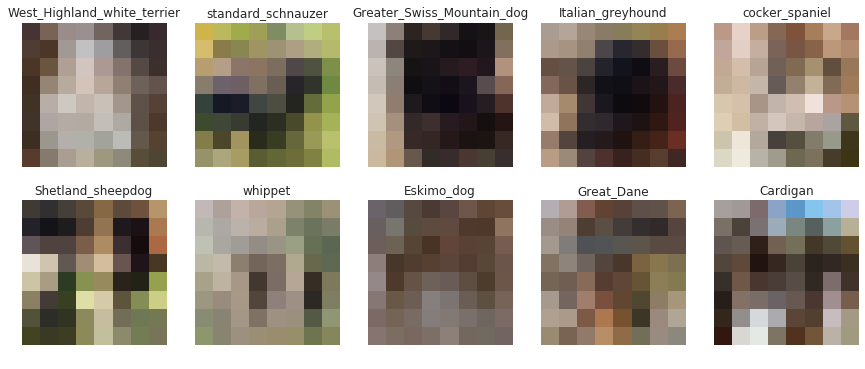


   -> Current resolution: 16 x 16 

Epoch 1/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.986     gen_loss=2.079     t=71s
Epoch 2/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.429     gen_loss=1.137     t=71s
Epoch 3/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.543     gen_loss=1.010     t=71s
Epoch 4/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.517     gen_loss=1.053     t=71s
Epoch 5/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.523     gen_loss=1.046     t=71s
Epoch 6/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.502     gen_loss=1.039     t=71s
Epoch 7/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.516     gen_loss=1.035     t=71s
Epoch 8/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.494     gen_loss=1.056     t=71s
Epoch 9/20     lr_g=6.0e-03     lr_d=6.0e-0

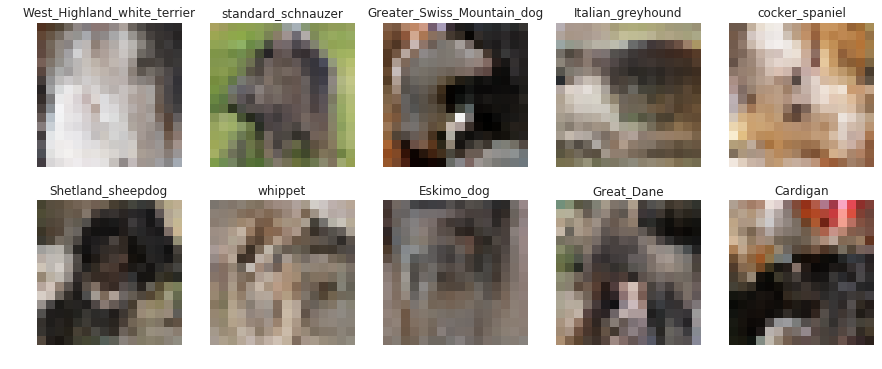

Epoch 11/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.441     gen_loss=1.121     t=71s
Epoch 12/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.446     gen_loss=1.135     t=71s
Epoch 13/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.416     gen_loss=1.150     t=71s
Epoch 14/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.382     gen_loss=1.181     t=71s
Epoch 15/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.384     gen_loss=1.189     t=71s
Epoch 16/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.322     gen_loss=1.243     t=71s
Epoch 17/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.333     gen_loss=1.244     t=71s
Epoch 18/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.305     gen_loss=1.269     t=71s
Epoch 19/20     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     d

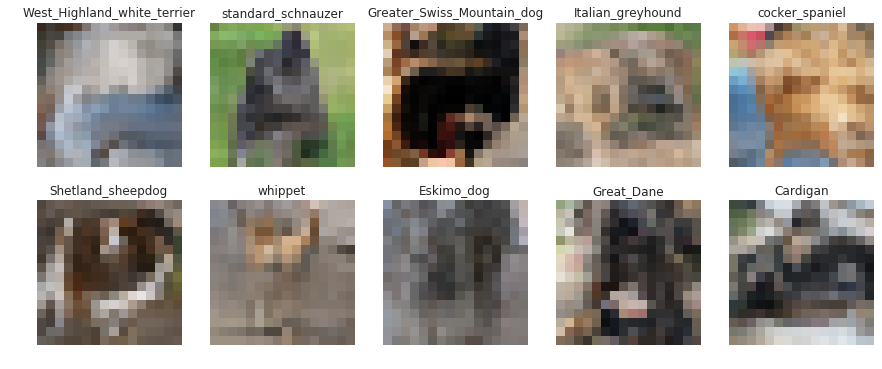


   -> Current resolution: 32 x 32 

Epoch 1/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.406     gen_loss=3.251     t=180s
Epoch 2/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.214     gen_loss=1.448     t=180s
Epoch 3/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.125     gen_loss=1.659     t=180s
Epoch 4/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.195     gen_loss=1.575     t=180s
Epoch 5/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.258     gen_loss=1.527     t=179s
Epoch 6/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.289     gen_loss=1.412     t=179s
Epoch 7/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.253     gen_loss=1.436     t=179s
Epoch 8/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.189     gen_loss=1.546     t=180s
Epoch 9/40     lr_g=6.0e-03     lr_

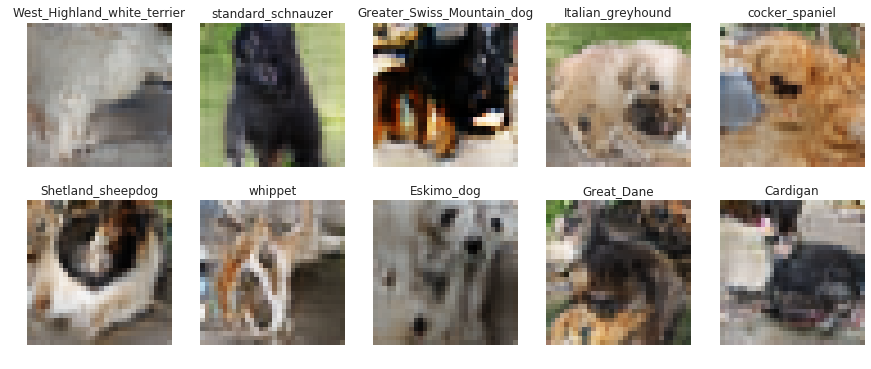

Epoch 11/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.096     gen_loss=1.638     t=180s
Epoch 12/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.074     gen_loss=1.678     t=180s
Epoch 13/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.101     gen_loss=1.630     t=179s
Epoch 14/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.044     gen_loss=1.711     t=180s
Epoch 15/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.028     gen_loss=1.749     t=179s
Epoch 16/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.012     gen_loss=1.797     t=179s
Epoch 17/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.003     gen_loss=1.752     t=180s
Epoch 18/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.998     gen_loss=1.789     t=180s
Epoch 19/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.99

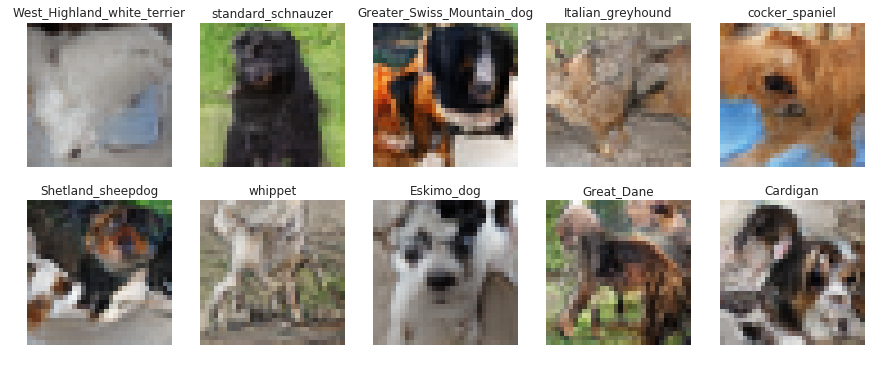

Epoch 21/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.939     gen_loss=1.899     t=179s
Epoch 22/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.935     gen_loss=1.937     t=180s
Epoch 23/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.910     gen_loss=1.978     t=180s
Epoch 24/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.035     gen_loss=1.885     t=179s
Epoch 25/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.912     gen_loss=1.951     t=180s
Epoch 26/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.919     gen_loss=1.996     t=183s
Epoch 27/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.881     gen_loss=2.060     t=188s
Epoch 28/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.866     gen_loss=2.049     t=186s
Epoch 29/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.99

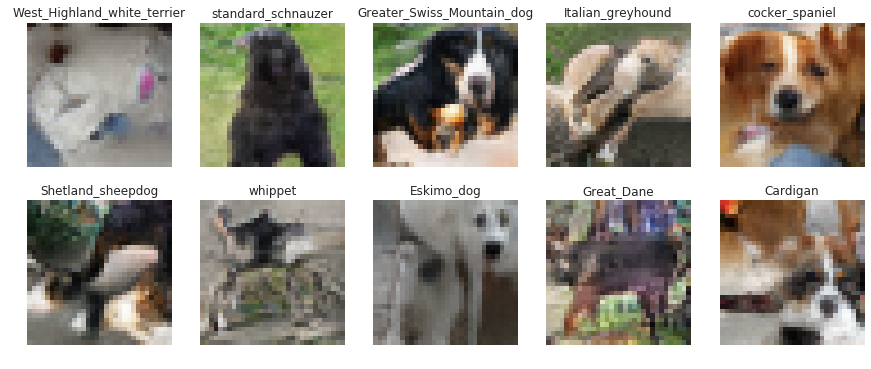

Epoch 31/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.799     gen_loss=2.225     t=180s
Epoch 32/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.811     gen_loss=2.239     t=180s
Epoch 33/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.804     gen_loss=2.240     t=179s
Epoch 34/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.813     gen_loss=2.248     t=180s
Epoch 35/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.800     gen_loss=2.241     t=179s
Epoch 36/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.799     gen_loss=2.263     t=179s
Epoch 37/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.769     gen_loss=2.293     t=180s
Epoch 38/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.815     gen_loss=2.243     t=180s
Epoch 39/40     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.99

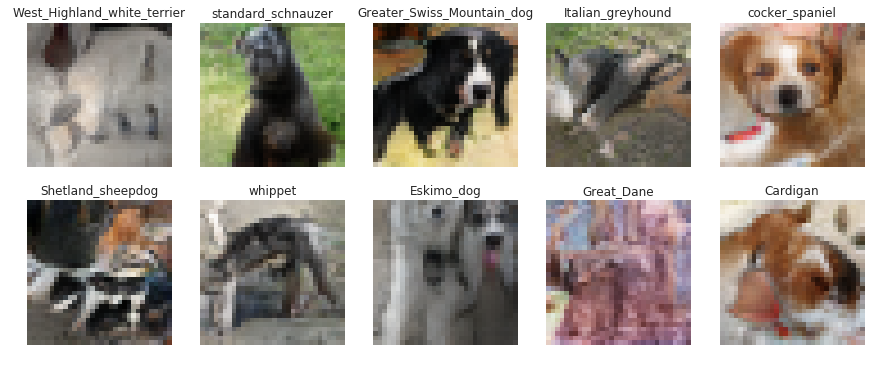


   -> Current resolution: 64 x 64 

Epoch 1/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=2.731     gen_loss=2.230     t=350s
Epoch 2/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.385     gen_loss=2.058     t=351s
Epoch 3/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.022     gen_loss=2.543     t=356s
Epoch 4/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.808     gen_loss=2.392     t=353s
Epoch 5/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=1.022     gen_loss=2.346     t=350s
Epoch 6/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.710     gen_loss=2.709     t=351s
Epoch 7/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.743     gen_loss=2.661     t=351s
Epoch 8/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.787     gen_loss=2.529     t=351s
Epoch 9/100     lr_g=6.0e-0

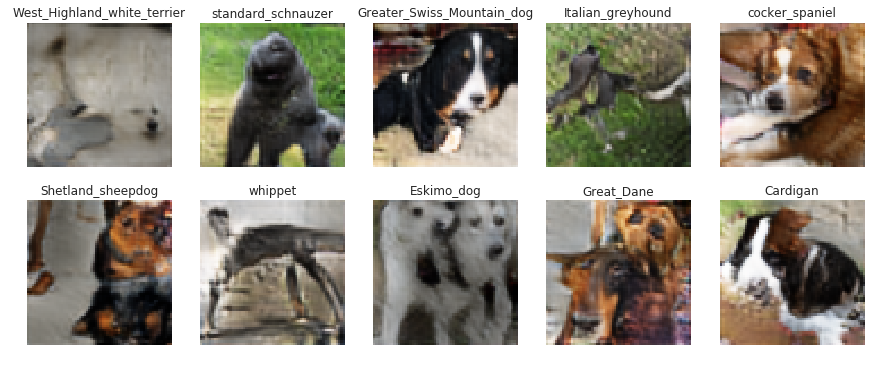

Epoch 11/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.837     gen_loss=2.477     t=350s
Epoch 12/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.812     gen_loss=2.464     t=350s
Epoch 13/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.774     gen_loss=2.603     t=350s
Epoch 14/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.785     gen_loss=2.597     t=350s
Epoch 15/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.830     gen_loss=2.445     t=350s
Epoch 16/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.828     gen_loss=2.526     t=350s
Epoch 17/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.783     gen_loss=2.497     t=350s
Epoch 18/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.758     gen_loss=2.528     t=350s
Epoch 19/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_d

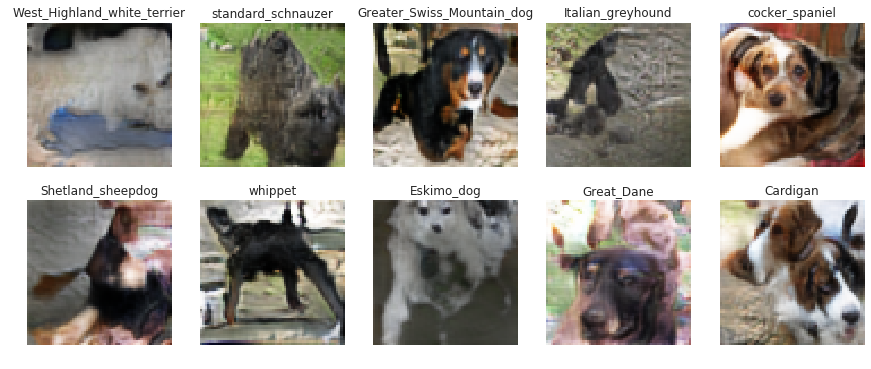

Epoch 21/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.779     gen_loss=2.596     t=350s
Epoch 22/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.746     gen_loss=2.697     t=350s
Epoch 23/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.747     gen_loss=2.654     t=350s
Epoch 24/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.710     gen_loss=2.678     t=350s
Epoch 25/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.786     gen_loss=2.630     t=350s


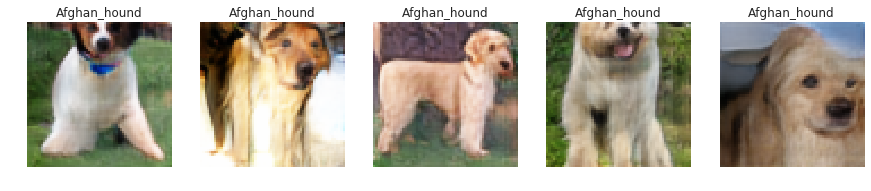

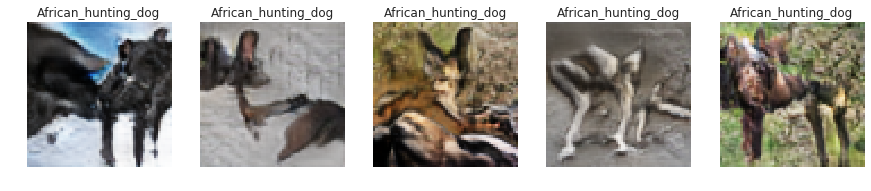

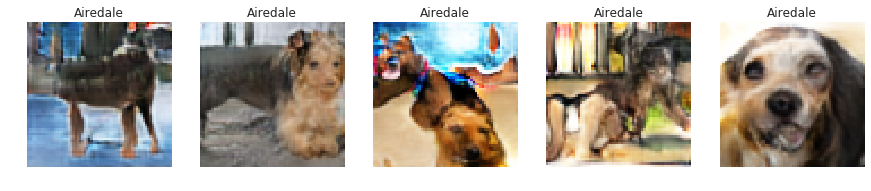

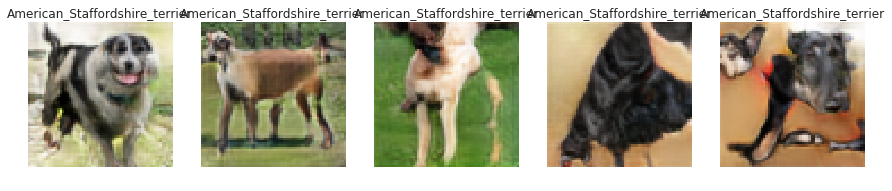

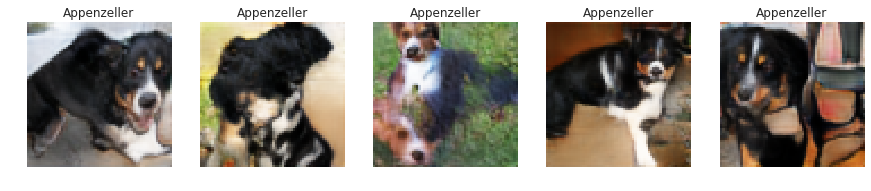

Epoch 26/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.689     gen_loss=2.632     t=350s
Epoch 27/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.705     gen_loss=2.723     t=350s
Epoch 28/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.692     gen_loss=2.774     t=350s
Epoch 29/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.726     gen_loss=2.744     t=350s
Epoch 30/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.751     gen_loss=2.771     t=350s


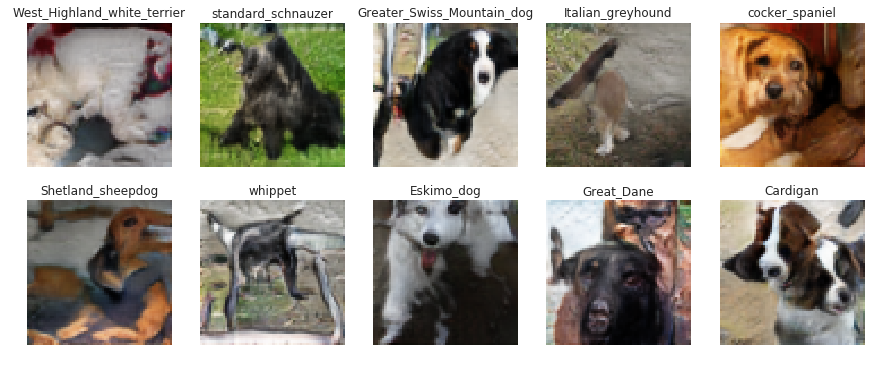

Epoch 31/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.672     gen_loss=2.668     t=350s
Epoch 32/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.705     gen_loss=2.797     t=350s
Epoch 33/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.675     gen_loss=2.782     t=350s
Epoch 34/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.754     gen_loss=2.801     t=350s
Epoch 35/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.634     gen_loss=2.835     t=350s
Epoch 36/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.622     gen_loss=2.977     t=350s
Epoch 37/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.676     gen_loss=2.833     t=350s
Epoch 38/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.607     gen_loss=3.013     t=350s
Epoch 39/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_d

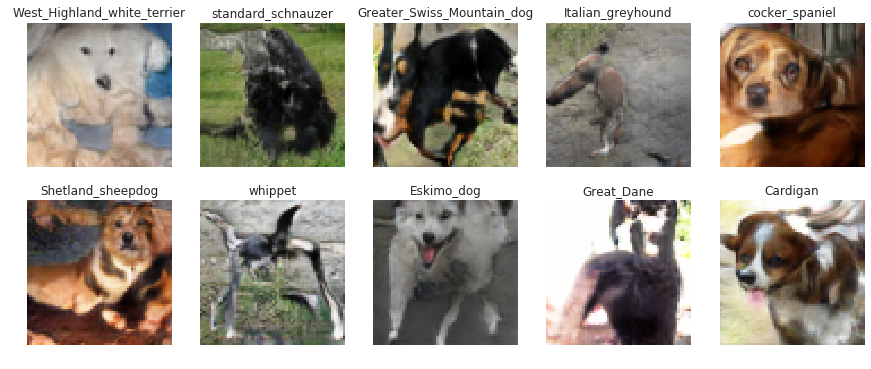

Epoch 41/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.602     gen_loss=3.108     t=350s
Epoch 42/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.590     gen_loss=3.132     t=350s
Epoch 43/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.823     gen_loss=2.776     t=350s
Epoch 44/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.561     gen_loss=3.188     t=350s
Epoch 45/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.589     gen_loss=3.100     t=350s
Epoch 46/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.596     gen_loss=3.119     t=350s
Epoch 47/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.540     gen_loss=3.161     t=350s
Epoch 48/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9900     disc_loss=0.622     gen_loss=3.131     t=350s
Epoch 49/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_d

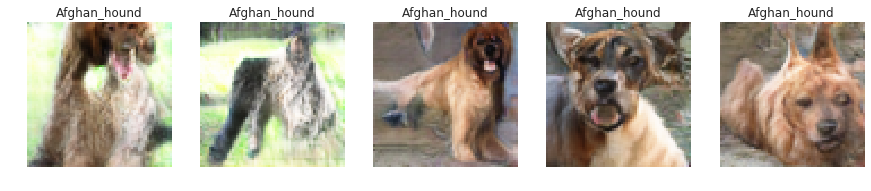

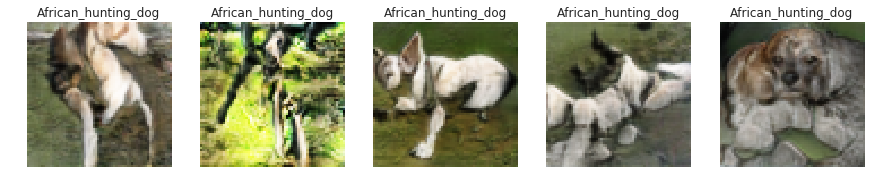

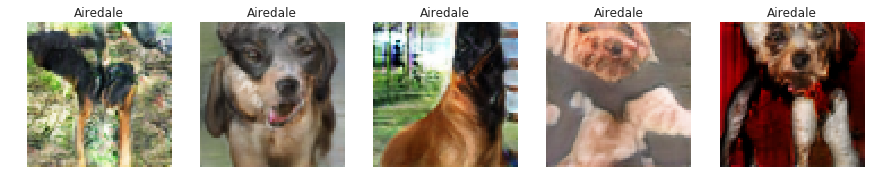

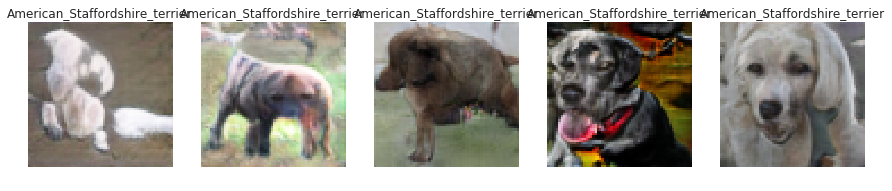

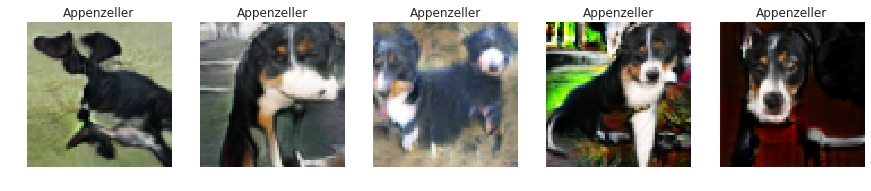

Epoch 51/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.582     gen_loss=3.374     t=350s
Epoch 52/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.516     gen_loss=3.547     t=350s
Epoch 53/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.507     gen_loss=3.549     t=350s
Epoch 54/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.746     gen_loss=3.019     t=350s
Epoch 55/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.514     gen_loss=3.311     t=350s
Epoch 56/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.545     gen_loss=3.376     t=350s
Epoch 57/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.543     gen_loss=3.507     t=350s
Epoch 58/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.516     gen_loss=3.398     t=350s
Epoch 59/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_d

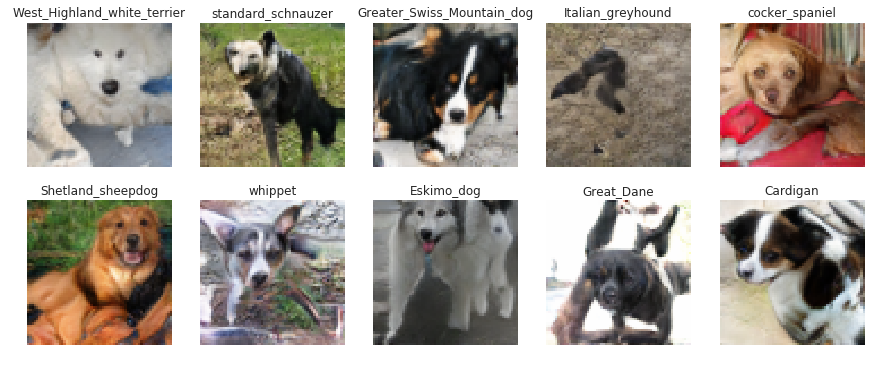

Epoch 61/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.736     gen_loss=3.162     t=350s
Epoch 62/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.493     gen_loss=3.183     t=350s
Epoch 63/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.496     gen_loss=3.510     t=350s
Epoch 64/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=1.069     gen_loss=2.854     t=350s
Epoch 65/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.460     gen_loss=3.414     t=350s
Epoch 66/100     lr_g=6.0e-03     lr_d=6.0e-03     ema_decay=0.9990     disc_loss=0.458     gen_loss=3.741     t=350s
Time limit reached, interrupting training.


In [41]:
infos = pro_gan.train(
    dataset=dataset,
    epochs=num_epochs,
    fade_in_percentage=fade_ins,
    batch_sizes=batch_sizes,
    ema_decays=ema_decays,
    verbose=1
)

In [42]:
# save_model_weights(pro_gan.gen, "gen_weights.pt")
# save_model_weights(pro_gan.gen_shadow, "gen_shadow_weights.pt")
# save_model_weights(pro_gan.dis, "dis_weights.pt")

## Loss Curves

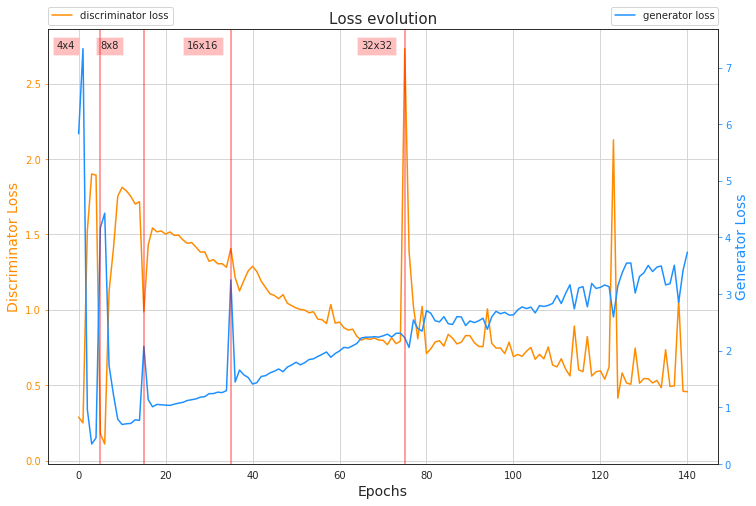

In [43]:
fig, ax1 = plt.subplots(figsize=(12, 8))

plt.plot(infos['discriminator_loss'], label='discriminator loss', c='darkorange')
ax1.set_ylabel('Discriminator Loss', color='darkorange', size=14)
ax1.tick_params(axis='y', colors='darkorange')
ax1.set_xlabel('Epochs', size=14)
plt.grid(True)
plt.legend(loc=(0, 1.01))

ax2 = ax1.twinx()
plt.plot(infos['generator_loss'], label='generator loss', c='dodgerblue')
ax2.set_ylabel('Generator Loss', color='dodgerblue', size=14)
ax2.tick_params(axis='y', colors='dodgerblue')
plt.legend(loc=(0.84, 1.01))

res = 4
for epoch in np.cumsum(num_epochs[:-1]):
    plt.axvline(epoch, c='r', alpha=0.5)
    plt.text(x=epoch-10, y=np.max(infos['generator_loss']), s=f'{res}x{res}', bbox=dict(facecolor='red', alpha=0.25))
    res *= 2

plt.title('Loss evolution', size=15)
plt.show()

## Generated Doggos

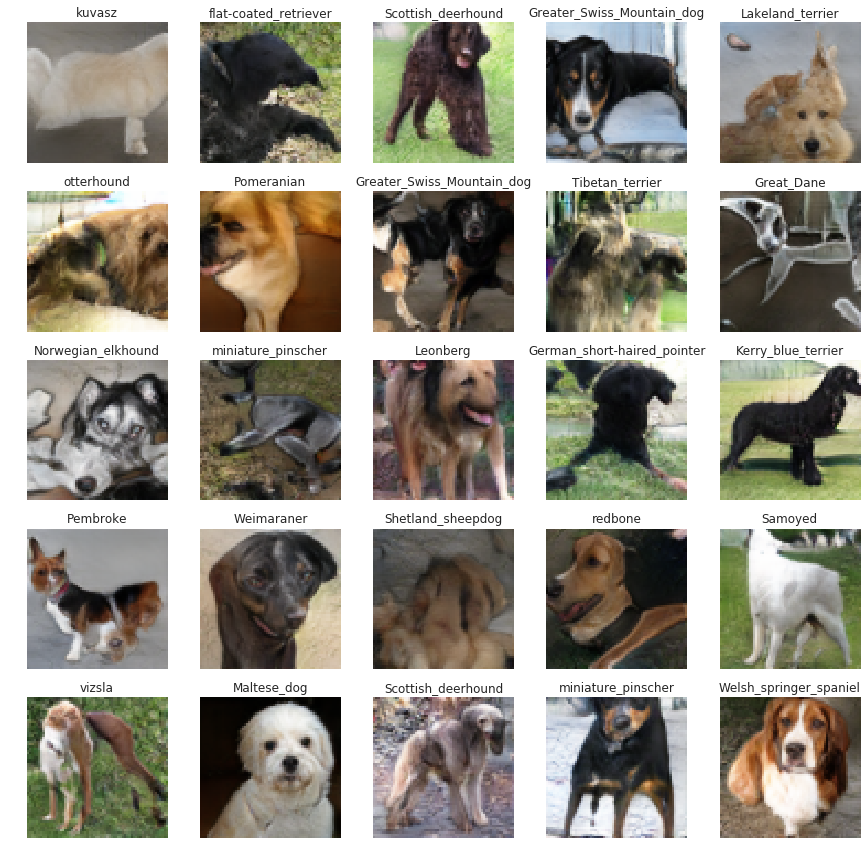

In [44]:
_ = pro_gan.generate(n_plot=25, n=batch_sizes[0])

# Submission

## Class sampling probabilities
I computed the public LB metric generating dogs only of one race to evaluate my GAN on specific races. It turned out that removing the worst races did not improve the score. 

In [45]:
use_class_probs = False

In [46]:
class_mifids = {0: 59.588, 1: 72.73, 2: 67.551, 3: 55.2313, 4: 106.411, 5: 91.73, 6: 76.835, 7: 116.532, 8: 133.186, 9: 97.613, 10: 60.579, 11: 88.973, 12: 100.450, 13: 70.434, 14: 109.0, 15: 67.517, 16: 70.190, 17: 64.704, 18: 93.84, 19: 85.469, 20: 76.62, 21: 59.845, 22: 88.898, 23: 106.39, 24: 82.955, 25: 65.451, 26: 58.066, 27: 51.016, 28: 86.535, 29: 55.7707, 30: 101.185, 31: 107.090, 32: 72.13, 33: 82.097, 34: 75.549, 35: 101.369, 36: 58.6547, 37: 58.2671, 38: 119.541, 39: 102.502, 40: 50.871, 41: 62.708, 42: 68.374, 43: 91.805, 44: 121.485, 45: 63.633, 46: 81.873, 47: 84.495, 48: 70.738, 49: 86.552, 50: 88.067, 51: 71.89, 52: 94.634, 53: 113.624, 54: 83.190, 55: 98.981, 56: 95.340, 57: 64.076, 58: 117.179, 59: 88.268, 60: 72.986, 61: 98.971, 62: 85.285, 63: 85.808, 64: 79.254, 65: 64.701, 66: 86.365, 67: 70.703, 68: 93.268, 69: 86.699, 70: 52.1906, 71: 113.921, 72: 97.362, 73: 91.260, 74: 86.280, 75: 79.446, 76: 93.833, 77: 90.210, 78: 78.724, 79: 71.74, 80: 63.501, 81: 68.04, 82: 63.95, 83: 64.699, 84: 67.830, 85: 74.525, 86: 95.0, 87: 80.052, 88: 66.01, 89: 82.810, 90: 89.005, 91: 70.746, 92: 71.503, 93: 74.91, 94: 93.378, 95: 82.145, 96: 83.216, 97: 82.569, 98: 65.660, 99: 104.155, 100: 92.105, 101: 81.490, 102: 61.454, 103: 93.271, 104: 75.405, 105: 64.791, 106: 67.661, 107: 96.165, 108: 66.574, 109: 80.197, 110: 89.485, 111: 98.295, 112: 73.864, 113: 59.862, 114: 61.0195, 115: 86.696, 116: 71.2, 117: 91.355, 118: 62.981, 119: 65.444}

In [47]:
threshold = 200 # All classes are kept
kept_classes = [k for k in class_mifids.keys() if class_mifids[k] < threshold]
print(f'Kept {len(kept_classes)} classes')

Kept 120 classes


In [48]:
probs = [class_mifids[k] for k in class_mifids.keys()]
probs = (probs - np.min(probs)) / np.sum(probs) / 4
probs = np.clip((1/120 - probs), 1/1000, 1/50)
probs /= np.sum(probs)

## Generating images

In [49]:
im_batch_size = 100
n_images = 10000

In [50]:
if os.path.exists('../output_images'):
    shutil.rmtree('../output_images', ignore_errors=True)
os.mkdir('../output_images')

In [51]:
for i_batch in tqdm(range(0, n_images, im_batch_size)):
    if use_class_probs:
        races = np.random.choice(kept_classes, size=im_batch_size, p=probs)
        races = torch.from_numpy(races).long()
        gen_images = pro_gan.generate(races=races, n=im_batch_size)
    else:
        gen_images = pro_gan.generate(n=im_batch_size)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'img_{i_batch+i_image}.png'))

In [52]:
print('Number of generated images :', len(os.listdir('../output_images')))

Number of generated images : 10000


In [53]:
shutil.make_archive('images', 'zip', '../output_images')

'/kaggle/working/images.zip'

In [54]:
print(f"Done in {(time.time() - begin)/60:.1f} minutes")

Done in 539.2 minutes


# Final words

I switched to ProGAN about 2/3 weeks after the beginning of the competition and quicly managed to hit 32 LB, using a setup I optimized on DCGans and tweaking the learning rate of the original repo. Afterwards I spent the rest of the competition trying to improve this architecture, and only managed to earn 2 points. Probably a bad choice, but as I was not very available during the last few weeks, it was easier for me.

Thanks for reading, and thanks to the Kaggle team for the huge work on the competition. 
